In [1]:
# import necessary libraries
import pandas as pd
from datetime import datetime,timedelta
import re

In [2]:
# Read the file
users = pd.read_csv('takehome_users.csv',encoding="ISO-8859-1", index_col='object_id')

In [4]:
# Read engagement file
engagement = pd.read_csv('takehome_user_engagement.csv',encoding="ISO-8859-1")
engagement['time_stamp'] =  pd.to_datetime(user_engagement.time_stamp,format='%Y-%m-%d %X')

In [5]:
Adoption = pd.DataFrame(pd.unique(engagement.user_id),columns=["user_id"])
Adoption['active'] = 0

In [6]:
for user, activeStatus in Adoption.iterrows():
    
    if len(engagement[user_engagement.user_id==user])>3:
        minTime_diff = timedelta(days=99)
        tempArray = engagement[engagement.user_id==user].reset_index()
        for place in range(len(tempArray)-2):
            time_dif = (tempArray.loc[place+2].time_stamp-tempArray.loc[place].time_stamp)
            if (minTime_diff > time_dif):
                minTime_diff = time_dif
        if minTime_diff <= timedelta(days=7):
            Adoption.loc[user,'active'] = 1

In [9]:
#Joining data from two files
data = users.join(Adoption,how='inner')
print(data.head())

         creation_time               name                       email  \
1  2014-04-22 03:53:30     Clausen August    AugustCClausen@yahoo.com   
2  2013-11-15 03:45:04      Poole Matthew      MatthewPoole@gustr.com   
3  2013-03-19 23:14:52  Bottrill Mitchell  MitchellBottrill@gustr.com   
4  2013-05-21 08:09:28    Clausen Nicklas   NicklasSClausen@yahoo.com   
5  2013-01-17 10:14:20          Raw Grace          GraceRaw@yahoo.com   

  creation_source  last_session_creation_time  opted_in_to_mailing_list  \
1    GUEST_INVITE                1.398139e+09                         1   
2      ORG_INVITE                1.396238e+09                         0   
3      ORG_INVITE                1.363735e+09                         0   
4    GUEST_INVITE                1.369210e+09                         0   
5    GUEST_INVITE                1.358850e+09                         0   

   enabled_for_marketing_drip  org_id  invited_by_user_id  user_id  active  
1                           0    

In [10]:
# Date Extraction
data['creation_time'] = pd.to_datetime(data.creation_time,format='%Y-%m-%d %X')

In [11]:
# Email extraction
def extractEmailSite(email=None):
    if email != None:
        site = re.search('@(.+?)\.', email).group(1)
        return site
    else:
        return None
data['email_site'] = pd.Series([extractEmailSite(email) for email in data['email']])

In [12]:
data['email_site_cat'] = data['email_site'].astype("category").cat.codes
data['creation_source_cat'] = data['creation_source'].astype("category").cat.codes

In [13]:
data['last_session_creation_time'] = data['last_session_creation_time'].map(lambda data: datetime.\
                                            fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),na_action='ignore')

data['last_session_creation_time'] = pd.to_datetime(data['last_session_creation_time'])

data['total_time_used'] = data['last_session_creation_time'] - data['creation_time']

data = data[data['total_time_used'] >= timedelta(days=0)]

data['total_time_used'] = data['total_time_used'].map(lambda data: data.total_seconds())

In [14]:
# Drop unused columns
encoded_data = data.drop('email_site',axis=1).drop('creation_source',axis=1)\
                   .drop('name',axis=1).drop('creation_time',axis=1)\
                   .drop('email',axis=1)
print(encoded_data.head())

  last_session_creation_time  opted_in_to_mailing_list  \
2        2014-03-30 23:45:04                         0   
4        2013-05-22 04:09:28                         0   
5        2013-01-22 05:14:20                         0   
6        2013-12-18 22:37:06                         0   
7        2012-12-20 08:24:32                         0   

   enabled_for_marketing_drip  org_id  invited_by_user_id  user_id  active  \
2                           0       1               316.0        3       1   
4                           0       1              5151.0        5       0   
5                           0     193              5240.0        6       0   
6                           0     197             11241.0        7       0   
7                           1      37                 NaN       10       0   

   email_site_cat  creation_source_cat  total_time_used  
2             229                    1       11736000.0  
4             819                    0          72000.0  
5       

In [15]:
#check null values
encoded_data.isnull().sum()

last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            1890
user_id                          0
active                           0
email_site_cat                   0
creation_source_cat              0
total_time_used                  0
dtype: int64

In [16]:
#Remove null values - invited_by_user_id
encoded_data['invited_by_user_id'].fillna(0, inplace=True)

In [17]:
encoded_data.dropna(axis=0, inplace=True)
encoded_data.isnull().sum()

last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
user_id                       0
active                        0
email_site_cat                0
creation_source_cat           0
total_time_used               0
dtype: int64

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [19]:
X = encoded_data.drop(['active','last_session_creation_time'],axis=1)

In [20]:
# Split Training and Test Data
X_train, X_test, y_train, y_test = train_test_split(X,\
    encoded_data.active, \
    test_size=0.33, \
    random_state=42,stratify=encoded_data.active)

#instatiate and train classifier
from sklearn.tree import DecisionTreeClassifier
clf = RandomForestClassifier(n_estimators=10,class_weight='balanced_subsample')#DecisionTreeClassifier()
print(X_train.head())
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)

print('Training Report')
report = classification_report(y_true = np.array(y_train), y_pred = predictions)
print(report)
print('Testing Report')
predictions = clf.predict(X_test)
report = classification_report(y_true = np.array(y_test), y_pred = predictions)
print(report)

      opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
6710                         1                           0     121   
2781                         0                           0     360   
59                           0                           0     325   
7514                         1                           1     279   
4111                         0                           0      37   

      invited_by_user_id  user_id  email_site_cat  creation_source_cat  \
6710                 0.0     9146             222                    3   
2781              9732.0     3780             222                    1   
59                   0.0       77             222                    4   
7514                 0.0    10218             819                    3   
4111                 0.0     5614              96                    3   

      total_time_used  
6710         158400.0  
2781         158400.0  
59          7416000.0  
7514         158400.0  
4111        12

>  __ The model performed well on Training data than test data__

Feature ranking:
1. total_time_used (0.800879)
2. user_id (0.059157)
3. org_id (0.052209)
4. invited_by_user_id (0.035984)
5. email_site_cat (0.024412)
6. creation_source_cat (0.017816)
7. opted_in_to_mailing_list (0.005665)
8. enabled_for_marketing_drip (0.003878)


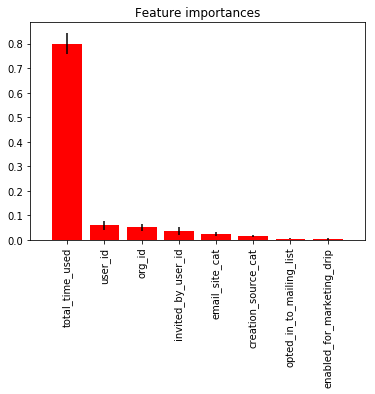

In [21]:
#feature engineering - finding features of importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns.values[indices[f]], importances[indices[f]]))
    #print("%d. %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
#plt.xticks(X_train.columns.values, indices)
plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()